In [1]:
from Solvers import adv_solver, span_solver, span_solver2
from Adversary import Adversary, Problem, to_str
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Examples import exact_k, threshold_k
from ElementDistinctness import ED
from copy import deepcopy as copy
import scipy
import cvxpy as cp
import itertools
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =100

In [2]:
class SpanProgram():
    def __init__(self, problem, I_dict):
        self.target = np.ones(problem.no_len)
        self.num_vects = np.sum([len(v) for i, v in I_dict.items()])
        self.ordered_I = [pair for pair in itertools.product(tuple(range(problem.n)), problem.alphabet)]
        self.I_to_mat = {}
        self.counter = 0
        self.vect_list = []
        self.ticks = []
        self.problem = problem
        for pair, v_set in I_dict.items():
            self.ticks.append(self.counter)
            self.I_to_mat[pair] = list(range(self.counter, self.counter + len(v_set)))
            self.counter += len(v_set)
            for vect in v_set:
                self.vect_list.append(vect)
            # self.vect_list.append(*v_set)
        
        self.A = np.array(self.vect_list).T 
    
    def get_activated_A(self, x):
        activated_A = np.zeros(self.A.shape)
        for i in range(len(x)):
            interval = self.I_to_mat[(i, x[i])]
            activated_A[:, interval] = self.A[:, interval]
        return activated_A
        
        
    def apply(x, witness):
        return get_activated_A(x) @ witness
    
    def visualize_A(self):
        plt.imshow(self.A)
        plt.xticks(self.ticks, self.ordered_I)
        plt.yticks(list(range(self.problem.no_len)), [to_str(no) for no in self.problem.no_instances])
        plt.colorbar()
        plt.show()
        
        

In [3]:
def rand_function(n, alpha='01'):
    yes = []
    no = []
    for s in itertools.product(*[alpha]*n):
        if np.random.randint(2):
            yes.append(s)
        else:
            no.append(s)
    return Problem(no, yes)

No:[(0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 1, 0), (0, 0, 0, 1, 0, 0), (0, 0, 1, 0, 0, 0), (0, 1, 0, 0, 0, 0), (1, 0, 0, 0, 0, 0)]
Yes:[(0, 0, 0, 0, 1, 1), (0, 0, 0, 1, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 1, 0, 1, 0), (0, 0, 1, 1, 0, 0), (0, 1, 0, 0, 0, 1), (0, 1, 0, 0, 1, 0), (0, 1, 0, 1, 0, 0), (0, 1, 1, 0, 0, 0), (1, 0, 0, 0, 0, 1), (1, 0, 0, 0, 1, 0), (1, 0, 0, 1, 0, 0), (1, 0, 1, 0, 0, 0), (1, 1, 0, 0, 0, 0)]


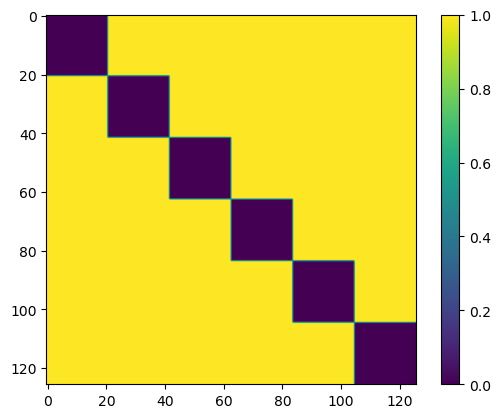

{'solver': 'MOSEK', 'verbose': True, 'mosek_params': {'MSK_IPAR_NUM_THREADS': 20}}
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 14 11:47:58 AM: Your problem has 15877 variables, 112 constraints, and 0 parameters.
(CVXPY) Jul 14 11:47:58 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 14 11:47:58 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 14 11:47:58 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 14 11:47:58 AM: Compiling problem (target solver=MOSEK).
(CVXPY)

In [14]:
prob = threshold_k(6, 2)
print(prob)
v, X = span_solver2(prob, 59.99, {'solver':'MOSEK', 'verbose': True, 'mosek_params': {'MSK_IPAR_NUM_THREADS': 20}})

15
size (126, 126)
60 66.408 3.16228031789229


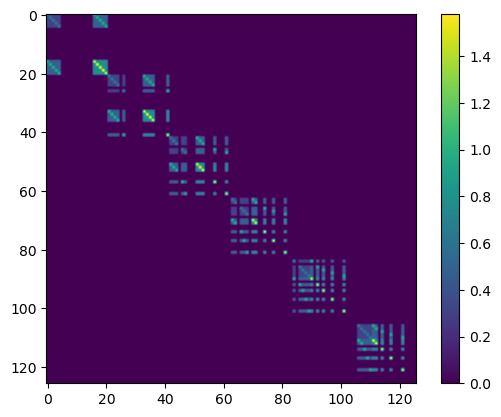

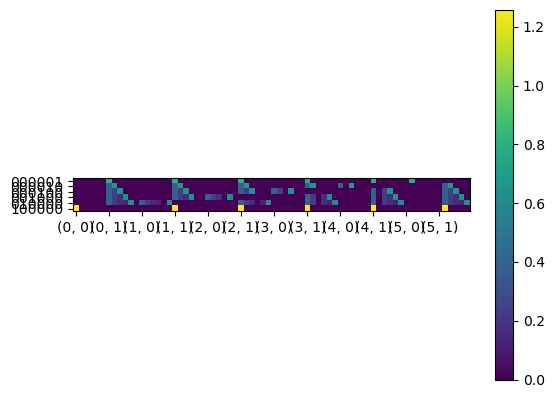

In [11]:
def get_cholesky_fact(A, eps_pow=15):
    for i in range(eps_pow,1,-1):
        print(i)
        try:
            curr_A = A + 10**-i * np.eye(A.shape[0])
            return np.round(scipy.linalg.cholesky(curr_A), i-1)
        except:
            pass
def decompose_cholesky(L, problem):
    partials = []
    for i in range(problem.n):
        full_partial = L[i * problem.len: (i+1)* problem.len, i * problem.len: (i+1)* problem.len][:problem.no_len, :]
        nonzero_columns = []
        for j in range(full_partial.shape[1]):
            v = full_partial[:, j]
            if np.linalg.norm(v) > 10**-6:
                # print('j', j)
                nonzero_columns.append(v)
        partials.append(np.array(nonzero_columns))
    return partials

def span_from_decomp(partials, problem):
    I = {}
    for j, b in itertools.product(range(problem.n), problem.alphabet):
        I[(j, b)] = []
        for i in range(partials[j].shape[1]):
            v = np.zeros(problem.no_len)
            for no_index in range(problem.no_len):
                no = problem.no_instances[no_index]
                if no[j] != b:
                    # print(j, i, no_index)
                    v[no_index] = partials[j][no_index, i]
            I[(j,b)].append(v)
    return SpanProgram(problem, I)
                
X2 = np.round(X, 5)
# print(X)
L = get_cholesky_fact(X2)
print('size', X2.shape)
print(np.linalg.matrix_rank(X2), np.trace(X2), v)
partials = decompose_cholesky(L, prob)
plt.imshow(X)
plt.colorbar()
plt.show()
sp = span_from_decomp(partials, prob)
sp.visualize_A()

In [12]:
np.trace(X)

66.40787850413494

In [13]:
print(v, np.max([X[i][i] for i in range(X.shape[0])]))
print('norm', np.linalg.norm(X, 2))
print('len', X.shape[0])
print('rank', np.linalg.matrix_rank(X2), np.linalg.matrix_rank(X))
print(np.trace(X2))
# print(np.real_if_close(np.linalg.eigvals(X),4)[0])

3.16228031789229 1.581138294042252
norm 6.64042414437694
len 126
rank 60 126
66.408


In [9]:
plt.imshow(L)
plt.colorbar()

NameError: name 'L' is not defined